In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/modified_ais_data.csv',nrows=10000)

In [3]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4


In [4]:
import math

def lat_lon_to_cartesian(lat, lon, R=6371):
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    x = R * math.cos(lat_rad) * math.cos(lon_rad)
    y = R * math.cos(lat_rad) * math.sin(lon_rad)
    z = R * math.sin(lat_rad)
    return x, y, z

def cartesian_to_lat_lon(x, y, z, R=6371):
    lon = math.degrees(math.atan2(y, x))
    lat = math.degrees(math.asin(z / R))
    return lat, lon


In [5]:
df[['x', 'y', 'z']] = df.apply(lambda row: pd.Series(lat_lon_to_cartesian(row['LAT'], row['LON'])), axis=1)

In [6]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7,976.189651,-5653.417795,2770.480464
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2,-462.261129,-5535.146877,3120.593645
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3,-2256.980451,-3543.426543,4789.552023
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5,2410.348516,-5537.896973,2027.697745
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4,-350.359001,-5579.067584,3056.287693


In [7]:
import numpy as np
def haversine(lat1, lon1, lat2, lon2, R=6371):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [8]:
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

In [9]:
def calculate_distances(group):
    group = group.sort_values(by="BaseDateTime")
    group["next_lat"] = group["LAT"].shift(-1)
    group["next_long"] = group["LON"].shift(-1)
    group["distance_km"] = group.apply(
        lambda row: haversine(row["LAT"], row["LON"], row["next_lat"], row["next_long"])
        if not np.isnan(row["next_lat"])
        else 0,
        axis=1,
    )
    return group.drop(columns=["next_lat", "next_long"])

In [10]:
df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)
df.head()

<ipython-input-10-e18fd20cbb70>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km
0,2022-03-31 00:02:32,111,IMO0000001,27.35372,-94.62546,0.4,228.6,-456.323030,-5640.208831,2927.363085,0.003950
1,2022-03-31 00:05:35,111,IMO0000001,27.35372,-94.62550,0.6,219.8,-456.326968,-5640.208513,2927.363085,0.008126
2,2022-03-31 00:08:34,111,IMO0000001,27.35377,-94.62556,0.2,221.7,-456.332668,-5640.205489,2927.368023,0.000000
3,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000998
4,2022-03-31 00:01:18,1056261,IMO1056261,26.11809,-80.14814,0.0,211.7,978.776450,-5636.091482,2804.658708,0.001997


In [11]:
def calculate_durations(group):
    # Ensure BaseDateTime is a datetime type
    group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])
    # Calculate the duration between consecutive points in seconds
    group['duration_seconds'] = group['BaseDateTime'].diff().dt.total_seconds()
    return group

In [12]:
df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)
df = df.reset_index(drop=True)
df.head()

<ipython-input-12-1fbd24d56e1c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds
0,2022-03-31 00:02:32,111,IMO0000001,27.35372,-94.62546,0.4,228.6,-456.323030,-5640.208831,2927.363085,0.003950,NaN
1,2022-03-31 00:05:35,111,IMO0000001,27.35372,-94.62550,0.6,219.8,-456.326968,-5640.208513,2927.363085,0.008126,183.0
2,2022-03-31 00:08:34,111,IMO0000001,27.35377,-94.62556,0.2,221.7,-456.332668,-5640.205489,2927.368023,0.000000,179.0
3,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000998,NaN
4,2022-03-31 00:01:18,1056261,IMO1056261,26.11809,-80.14814,0.0,211.7,978.776450,-5636.091482,2804.658708,0.001997,61.0


In [13]:
# Define constants
KNOTS_TO_METERS_PER_SEC = 0.514444
df['sog_mps'] = df['SOG'].apply(lambda x: x * KNOTS_TO_METERS_PER_SEC)
df['cog_radians'] = df['COG'].apply(lambda x: np.radians(x))


In [14]:
import pandas as pd
import numpy as np

# Define the function to calculate magnitude
def calculate_magnitude(df):
    # Calculate the velocity components
    df['v_x'] = df['sog_mps'] * np.cos(df['cog_radians'])
    df['v_y'] = df['sog_mps'] * np.sin(df['cog_radians'])

    # Calculate the magnitude
    df['magnitude'] = np.sqrt(df['v_x']**2 + df['v_y']**2)

    # Drop the v_x and v_y columns
    df.drop(columns=['v_x', 'v_y'], inplace=True)

    return df

# Apply the function
df = calculate_magnitude(df)


In [15]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds,sog_mps,cog_radians,magnitude
0,2022-03-31 00:02:32,111,IMO0000001,27.35372,-94.62546,0.4,228.6,-456.323030,-5640.208831,2927.363085,0.003950,NaN,0.205778,3.989823,0.205778
1,2022-03-31 00:05:35,111,IMO0000001,27.35372,-94.62550,0.6,219.8,-456.326968,-5640.208513,2927.363085,0.008126,183.0,0.308666,3.836234,0.308666
2,2022-03-31 00:08:34,111,IMO0000001,27.35377,-94.62556,0.2,221.7,-456.332668,-5640.205489,2927.368023,0.000000,179.0,0.102889,3.869395,0.102889
3,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000998,NaN,0.051444,3.848451,0.051444
4,2022-03-31 00:01:18,1056261,IMO1056261,26.11809,-80.14814,0.0,211.7,978.776450,-5636.091482,2804.658708,0.001997,61.0,0.000000,3.694862,0.000000


In [16]:
df = df[['x','y','z','duration_seconds','distance_km','sog_mps','cog_radians',
         'magnitude']]

In [17]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians,magnitude
0,-456.323030,-5640.208831,2927.363085,NaN,0.003950,0.205778,3.989823,0.205778
1,-456.326968,-5640.208513,2927.363085,183.0,0.008126,0.308666,3.836234,0.308666
2,-456.332668,-5640.205489,2927.368023,179.0,0.000000,0.102889,3.869395,0.102889
3,978.775466,-5636.091653,2804.658708,NaN,0.000998,0.051444,3.848451,0.051444
4,978.776450,-5636.091482,2804.658708,61.0,0.001997,0.000000,3.694862,0.000000


In [18]:
df.dropna(inplace=True)

In [19]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians,magnitude
1,-456.326968,-5640.208513,2927.363085,183.0,0.008126,0.308666,3.836234,0.308666
2,-456.332668,-5640.205489,2927.368023,179.0,0.000000,0.102889,3.869395,0.102889
4,978.776450,-5636.091482,2804.658708,61.0,0.001997,0.000000,3.694862,0.000000
5,978.778417,-5636.091140,2804.658708,78.0,0.003994,0.000000,3.801327,0.000000
6,978.774482,-5636.091823,2804.658708,71.0,0.001494,0.000000,3.885103,0.000000


### Model

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, MultiHeadAttention, LayerNormalization, Dropout,
    TimeDistributed, Masking
)
from sklearn.preprocessing import MinMaxScaler

# --------------------------- MASKING FUNCTIONS ---------------------------

# def create_look_ahead_mask(seq_len):
#     """Generates an upper triangular matrix filled with -inf to mask future tokens."""
#     mask = np.triu(np.ones((seq_len, seq_len)), k=1)  # Upper triangular (excluding diagonal)
#     return tf.convert_to_tensor(mask * -1e9)  # Convert to large negative values

def create_look_ahead_mask(seq_len):
    return tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) * -1e9

def create_padding_mask(seq):
    """Creates a mask where 1s indicate padding tokens (timesteps with all features zero)."""
    # seq shape: (batch_size, seq_len, feature_dim)
    # mask = tf.reduce_all(tf.math.equal(seq, 0), axis=-1)  # (batch_size, seq_len)
    mask = tf.reduce_all(tf.math.equal(seq, -1), axis=-1)
    mask = tf.cast(mask, tf.float32)  # 1.0 where padding, 0.0 otherwise
    return mask[:, tf.newaxis, tf.newaxis, :]  # Shape: (batch, 1, 1, seq_len)

# ------------------------- POSITIONAL ENCODING -------------------------

# class PositionalEncoding(tf.keras.layers.Layer):
#     def __init__(self, d_model, **kwargs):
#         super(PositionalEncoding, self).__init__(**kwargs)
#         self.d_model = d_model

#     def call(self, inputs):
#         seq_len = tf.shape(inputs)[1]
#         pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
#         i = tf.range(self.d_model, dtype=tf.float32)[tf.newaxis, :]
#         angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(self.d_model, tf.float32))

#         angle_rads = pos * angle_rates  # Shape: (seq_len, d_model)

#         # Apply sin to even indices and cos to odd indices
#         sin_mask = tf.cast(tf.math.equal(i % 2, 0), tf.float32)
#         cos_mask = tf.cast(tf.math.equal(i % 2, 1), tf.float32)

#         pe = tf.sin(angle_rads) * sin_mask + tf.cos(angle_rads) * cos_mask
#         return inputs + pe

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

        # Compute positional encodings
        pos = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(pos * div_term)
        pe[:, 1::2] = np.cos(pos * div_term)
        self.positional_encoding = tf.convert_to_tensor(pe[np.newaxis, :, :], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.positional_encoding[:, :seq_len, :]

# ------------------------- ENCODER LAYER -------------------------

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, ff_dim, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])

    def call(self, inputs, padding_mask):
        attn_output = self.mha(inputs, inputs, attention_mask=padding_mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.norm2(out1 + ffn_output)

# ------------------------- DECODER LAYER -------------------------

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, ff_dim, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.norm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])

    def call(self, inputs, encoder_outputs, combined_mask, padding_mask):
        # Self-attention with combined mask (look-ahead + padding)
        attn1 = self.mha1(inputs, inputs, attention_mask=combined_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.norm1(inputs + attn1)
        # Encoder-decoder attention
        attn2 = self.mha2(out1, encoder_outputs, attention_mask=padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.norm2(out1 + attn2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        return self.norm3(out2 + ffn_output)

# ------------------------- BUILD TRANSFORMER -------------------------

from tensorflow.keras.layers import Lambda

def build_transformer(input_shape, target_shape, num_layers=4, num_heads=4, d_model=16, ff_dim=64):
    encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
    decoder_inputs = Input(shape=target_shape, name="decoder_inputs")

    # Encoder masks
    enc_padding_mask = Lambda(lambda x: create_padding_mask(x))(encoder_inputs)

    # Decoder masks
    dec_padding_mask = Lambda(lambda x: create_padding_mask(x))(decoder_inputs)
    # look_ahead_mask = Lambda(lambda x: create_look_ahead_mask(target_shape[0]))(decoder_inputs)
    look_ahead_mask = Lambda(lambda x: create_look_ahead_mask(tf.shape(x)[1]))(decoder_inputs)
    combined_mask = Lambda(lambda x: tf.maximum(x[0], x[1]))([look_ahead_mask, dec_padding_mask])

    # Encoder
    x = Masking(mask_value=0.0)(encoder_inputs)
    x = PositionalEncoding(d_model)(x)
    for _ in range(num_layers):
        x = EncoderLayer(num_heads, d_model, ff_dim)(x, enc_padding_mask)
    encoder_outputs = x

    # Decoder
    x = Masking(mask_value=0.0)(decoder_inputs)
    x = PositionalEncoding(d_model)(x)
    for _ in range(num_layers):
        x = DecoderLayer(num_heads, d_model, ff_dim)(x, encoder_outputs, combined_mask, enc_padding_mask)

    outputs = TimeDistributed(Dense(target_shape[-1], activation="linear"))(x)
    return Model([encoder_inputs, decoder_inputs], outputs)

# ------------------------- TRAINING -------------------------

# Simulated dataset
feature_dim = 8
seq_length = 10

# Create Transformer model
model = build_transformer(
    (seq_length, feature_dim),
    (seq_length, feature_dim),
    num_layers=4,
    num_heads=4,
    d_model=feature_dim,
    ff_dim=64
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])

# Normalize Data
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)


def create_sequences(data, seq_length):
    X, decoder_inputs, decoder_targets = [], [], []
    for i in range(len(data) - 2 * seq_length + 1):
        X.append(data[i:i + seq_length])
        start_token = data[i + seq_length - 1]
        decoder_in = np.vstack([
            start_token,
            data[i + seq_length:i + seq_length + seq_length - 1]
        ])
        decoder_target = data[i + seq_length:i + seq_length + seq_length]
        decoder_inputs.append(decoder_in)
        decoder_targets.append(decoder_target)
    return np.array(X), np.array(decoder_inputs), np.array(decoder_targets)


X_train, decoder_inputs_train, decoder_targets_train = create_sequences(scaled_train, seq_length)
X_test, decoder_inputs_test, decoder_targets_test = create_sequences(scaled_test, seq_length)

# Train model
model.fit(
    [X_train, decoder_inputs_train],
    decoder_targets_train,
    validation_data=([X_test, decoder_inputs_test], decoder_targets_test),
    epochs=10,
    batch_size=32
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 61ms/step - accuracy: 0.3386 - loss: 0.1825 - val_accuracy: 0.6013 - val_loss: 0.0264
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5794 - loss: 0.0278 - val_accuracy: 0.6918 - val_loss: 0.0197
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.6726 - loss: 0.0215 - val_accuracy: 0.7163 - val_loss: 0.0180
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.7022 - loss: 0.0187 - val_accuracy: 0.7275 - val_loss: 0.0174
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.7152 - loss: 0.0177 - val_accuracy: 0.7311 - val_loss: 0.0173
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7156 - loss: 0.0177 - val_accuracy: 0.7340 - val_loss: 0.0169
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.7318 - loss: 0.0165 - val_accuracy: 0.7423 - val_loss: 0.0168
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.7381 - loss: 0.0165 - val_accurac

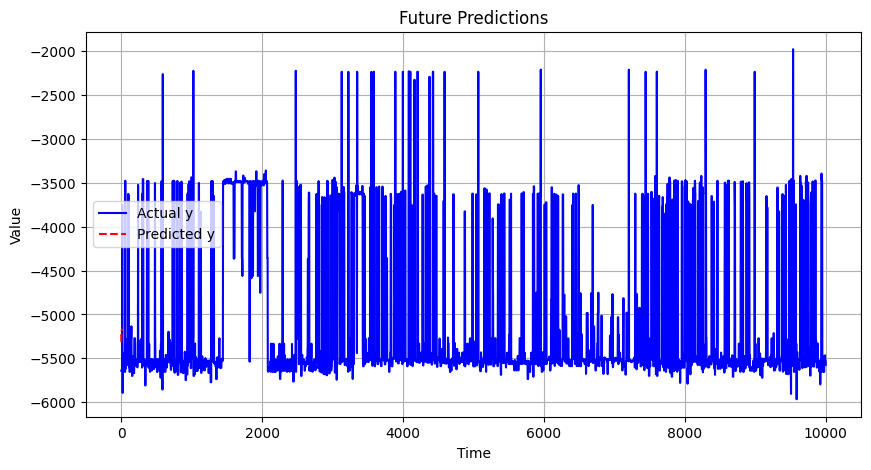

In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Initialize the PositionalEncoding Layer (This is already in your code)
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

        # Compute positional encodings
        pos = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(pos * div_term)
        pe[:, 1::2] = np.cos(pos * div_term)
        self.positional_encoding = tf.convert_to_tensor(pe[np.newaxis, :, :], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.positional_encoding[:, :seq_len, :]

# Assuming `model` is already built, trained, and compiled

# Simulated test data (using your scaled test data, assuming `df` exists)
future_steps = 20  # Number of future steps to predict

# Get the last test sequence from the dataset for prediction
encoder_input = X_test[-1].reshape(1, seq_length, X_train.shape[2])

# Initialize decoder input with zeros or last known value (you can choose to start with zeros)
decoder_input = np.zeros((1, seq_length, X_train.shape[2]))

# Apply positional encoding to the inputs (same as during training)
encoder_input_pos_encoded = PositionalEncoding(d_model)(encoder_input)
decoder_input_pos_encoded = PositionalEncoding(d_model)(decoder_input)

# Prepare an empty list to store future predictions
future_predictions = []

for step in range(future_steps):
    # Predict next step (forward pass using the model)
    pred = model.predict([encoder_input_pos_encoded, decoder_input_pos_encoded], verbose=0)

    # Extract the last predicted time step (next step prediction)
    next_pred = pred[0, -1, :]

    # Store the prediction in the future predictions list
    future_predictions.append(next_pred)

    # Shift decoder input and insert the new prediction at the last timestep
    decoder_input = np.roll(decoder_input, -1, axis=1)
    decoder_input[0, -1, :] = next_pred  # Insert new prediction at the last timestep

    # Apply positional encoding again to the updated decoder input
    decoder_input_pos_encoded = PositionalEncoding(d_model)(decoder_input)  # Pass d_model here

# Convert future predictions to a numpy array
future_predictions = np.array(future_predictions)

# Convert predictions back to the original scale (inverse transform using MinMaxScaler)
future_predictions = scaler.inverse_transform(future_predictions)

# Ensure column count matches predictions (select the correct number of columns from df)
expected_columns = df.columns[:future_predictions.shape[1]]  # Select the correct number of columns

# Create a DataFrame to store the forecasted values
forecast_df = pd.DataFrame(future_predictions, columns=expected_columns)

# Plot Actual vs. Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(df["y"], label="Actual y", color="blue")  # Assuming 'y' is one of your columns
plt.plot(forecast_df["y"], label="Predicted y", color="red", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Future Predictions")
plt.grid()
plt.show()


### manually calculating k,q,v


In [31]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, Dense, Embedding, Dropout, LayerNormalization
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

# ======== Positional Encoding ========
def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    pos_encoding = pos * angle_rates
    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# ======== Masking Functions ========
def create_look_ahead_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  # Lower triangular matrix
    mask = mask * -1e9  # Apply mask (set future positions to large negative values)
    mask = tf.expand_dims(mask, axis=0)  # Add batch dimension (1, seq_len, seq_len)
    mask = tf.expand_dims(mask, axis=0)  # Add head dimension (1, 1, seq_len, seq_len)
    return mask

# ======== Multi-Head Attention ========
class MultiHeadAttention(Layer):
    def __init__(self, num_heads, d_model):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_model = d_model  # Add this line
        self.depth = d_model // num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)
        scaled_attention_logits = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        if mask is not None:
            scaled_attention_logits += mask
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        return self.dense(tf.reshape(output, (batch_size, -1, self.d_model)))  # Now uses valid d_model

# ======== Encoder Layer ========
class EncoderLayer(Layer):
    def __init__(self, num_heads, d_model, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads, d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, mask=None):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.norm2(out1 + ffn_output)

# ======== Encoder ========
class Encoder(Layer):
    def __init__(self, num_layers, num_heads, d_model, ff_dim, input_dim, max_seq_len, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.input_projection = Dense(d_model)  # Project input features to d_model
        self.pos_encoding = get_positional_encoding(max_seq_len, d_model)
        self.enc_layers = [EncoderLayer(num_heads, d_model, ff_dim, dropout_rate) for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rate)

    def call(self, x, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.input_projection(x)  # Project input from (batch, seq_len, 8) to (batch, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)
        for enc_layer in self.enc_layers:
            x = enc_layer(x, mask)
        return x

# ======== Decoder Layer ========
class DecoderLayer(Layer):
    def __init__(self, num_heads, d_model, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.input_projection = Dense(d_model)  # Project decoder input to d_model
        self.self_mha = MultiHeadAttention(num_heads, d_model)
        self.cross_mha = MultiHeadAttention(num_heads, d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.norm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        x = self.input_projection(x)  # Project input to d_model
        attn1 = self.self_mha(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.norm1(x + attn1)
        attn2 = self.cross_mha(out1, enc_output, enc_output, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.norm2(out1 + attn2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        return self.norm3(out2 + ffn_output)

# ======== Transformer Model ========
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, num_heads, d_model, ff_dim, input_dim, max_seq_len, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers, num_heads, d_model, ff_dim, input_dim, max_seq_len, dropout_rate)
        self.decoder = DecoderLayer(num_heads, d_model, ff_dim, dropout_rate)
        self.final_layer = Dense(input_dim)  # Predict original feature dimension

    def call(self, inputs):
        enc_input, dec_input, enc_mask, look_ahead_mask, dec_padding_mask = inputs
        enc_output = self.encoder(enc_input, enc_mask)
        dec_output = self.decoder(dec_input, enc_output, look_ahead_mask, dec_padding_mask)
        return self.final_layer(dec_output)

# ======== Learning Rate Scheduler ========
class CustomSchedule(LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        return self.d_model ** -0.5 * tf.minimum(step ** -0.5, step * self.warmup_steps ** -1.5)

# ======== Loss Function ========
def loss_function(y_true, y_pred):
    # Create mask where y_true is not padding (0)
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=tf.float32)
    # Compute squared error between predictions and targets
    squared_error = tf.square(y_true - y_pred)
    # Apply mask to ignore padded positions
    masked_squared_error = squared_error * mask
    # Return mean of the masked errors
    return tf.reduce_mean(masked_squared_error)

# ======== Accuracy Function ========
def accuracy_function(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    match = tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32)
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match * mask) / tf.reduce_sum(mask)

# ======== Data Preparation ========
def create_sequences(data, seq_length):
    X, decoder_inputs, decoder_targets = [], [], []
    # Create sequences with proper alignment
    for i in range(len(data) - seq_length * 2 + 1):
        # Encoder input
        X.append(data[i:i+seq_length])

        # Decoder input (starts with last encoder element)
        decoder_in = data[i+seq_length-1:i+seq_length*2-1]
        decoder_inputs.append(decoder_in)

        # Decoder target
        decoder_target = data[i+seq_length:i+seq_length*2]
        decoder_targets.append(decoder_target)

    return (
        np.array(X),
        np.array(decoder_inputs),
        np.array(decoder_targets)
    )

# ======== Masking Functions ========
def create_padding_mask(seq):
    # Check if all features are padding (-1) for each position
    mask = tf.reduce_all(tf.math.equal(seq, -1), axis=-1)  # Reduces over features
    mask = tf.cast(mask, tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]  # Shape: (batch_size, 1, 1, seq_len)

def create_masks(X, decoder_inputs):
    batch_size = X.shape[0]  # Use numpy array shape instead of tf.shape
    seq_len = decoder_inputs.shape[1]

    enc_padding_mask = create_padding_mask(X)
    look_ahead_mask = create_look_ahead_mask(seq_len)
    look_ahead_mask = tf.tile(look_ahead_mask, [batch_size, 1, 1, 1])
    dec_padding_mask = create_padding_mask(decoder_inputs)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

# ======== Model Setup ========
num_layers = 4
num_heads = 8
d_model = 128
ff_dim = 512
input_dim = 8  # Matches your input feature dimension (scaled_train.shape[1])
max_seq_len = 50
dropout_rate = 0.1
seq_length = 10

transformer = Transformer(num_layers, num_heads, d_model, ff_dim, input_dim, max_seq_len, dropout_rate)
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Remove accuracy metric (not applicable for regression)
transformer.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

print('scaled_train shape: ',scaled_train.shape)  # Make sure it's 2D, something like (num_samples, feature_dim)
X_train, decoder_inputs_train, decoder_targets_train = create_sequences(scaled_train, seq_length)
X_test, decoder_inputs_test, decoder_targets_test = create_sequences(scaled_test, seq_length)


enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(X_train, decoder_inputs_train)

batch_size = 64
epochs = 1

# Correct mask creation for training and validation data
enc_padding_mask_train, look_ahead_mask_train, dec_padding_mask_train = create_masks(X_train, decoder_inputs_train)
enc_padding_mask_test, look_ahead_mask_test, dec_padding_mask_test = create_masks(X_test, decoder_inputs_test)

# Ensure all input arrays have the same number of samples
print("Training input shapes:")
print(f"X_train: {X_train.shape}")
print(f"decoder_inputs_train: {decoder_inputs_train.shape}")
print(f"enc_padding_mask_train: {enc_padding_mask_train.shape}")
print(f"look_ahead_mask_train: {look_ahead_mask_train.shape}")
print(f"dec_padding_mask_train: {dec_padding_mask_train.shape}")

transformer.fit(
    [X_train, decoder_inputs_train, enc_padding_mask_train, look_ahead_mask_train, dec_padding_mask_train],
    decoder_targets_train,
    validation_data=(
        [X_test, decoder_inputs_test, enc_padding_mask_test, look_ahead_mask_test, dec_padding_mask_test],
        decoder_targets_test
    ),
    batch_size=batch_size,
    epochs=epochs
)

# ======== Model Evaluation ========
# ======== Model Evaluation ========
# Use TEST masks (created with X_test and decoder_inputs_test)
eval_loss, eval_acc = transformer.evaluate(
    [X_test, decoder_inputs_test, enc_padding_mask_test, look_ahead_mask_test, dec_padding_mask_test],
    decoder_targets_test
)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_acc:.4f}")

scaled_train shape:  (6397, 8)
Training input shapes:
X_train: (6378, 10, 8)
decoder_inputs_train: (6378, 10, 8)
enc_padding_mask_train: (6378, 1, 1, 10)
look_ahead_mask_train: (6378, 1, 10, 10)
dec_padding_mask_train: (6378, 1, 1, 10)
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - accuracy: 0.1807 - loss: 1.1361 - val_accuracy: 0.6159 - val_loss: 0.0506
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6011 - loss: 0.0526
Test Loss: 0.0506, Test Accuracy: 0.6159


In [35]:
def predict_future(model, X_train, future_steps, scaler, seq_length):
    future_predictions = []

    # Ensure that X_train has a batch dimension
    if X_train.ndim == 2:
        X_train = np.expand_dims(X_train, axis=0)  # Add batch dimension if necessary

    # Get the last `seq_length` time steps for the decoder input
    decoder_input = X_train[0, -seq_length:, :]  # Last 'seq_length' values from the training data
    decoder_input = np.expand_dims(decoder_input, axis=0)  # Ensure batch dimension is present

    # Apply Positional Encoding to the decoder input
    seq_len = decoder_input.shape[1]  # This should match the length of your input sequence
    pos_encoding_layer = get_positional_encoding(seq_len, X_train.shape[2])  # Use the correct input features size
    decoder_input_pos_encoded = pos_encoding_layer  # Get the positional encoding directly

    # Create dummy masks (since we don't need them during prediction)
    look_ahead_mask = np.zeros((1, seq_len, seq_len))  # No look-ahead mask
    dec_padding_mask = np.zeros((1, 1, seq_len))  # No padding mask

    # Predict future steps
    for step in range(future_steps):
        # Predict the next step using the model
        pred = model.predict([X_train, decoder_input_pos_encoded, look_ahead_mask, look_ahead_mask, dec_padding_mask], verbose=0)

        # Extract the last predicted time step
        next_pred = pred[0, -1, :]  # Get the last prediction (next time step)

        # Append the prediction to the future predictions list
        future_predictions.append(next_pred)

        # Update the decoder input by rolling it to insert the new prediction
        decoder_input = np.roll(decoder_input, -1, axis=1)  # Shift the sequence by 1 step
        decoder_input[0, -1, :] = next_pred  # Insert the new prediction at the last position

        # Apply positional encoding to the updated decoder input
        decoder_input_pos_encoded = get_positional_encoding(decoder_input.shape[1], X_train.shape[2])

    # Convert the future predictions to their original scale using the scaler
    future_predictions = np.array(future_predictions)
    future_predictions = scaler.inverse_transform(future_predictions)  # Convert back to original scale

    # Convert predictions to DataFrame (ensure column consistency)
    expected_columns = df.columns[:future_predictions.shape[1]]  # Adjust if necessary
    forecast_df = pd.DataFrame(future_predictions, columns=expected_columns)

    return forecast_df

# Set the number of future steps to predict
future_steps = 10  # Number of steps to predict into the future
forecast_df = predict_future(transformer, scaled_train, future_steps, scaler, seq_length)

# Plot Actual vs. Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(df["y"], label="Actual y", color="blue")  # Replace "y" with actual target column
plt.plot(forecast_df["y"], label="Predicted y", color="red", linestyle="dashed")  # Replace "y" with actual target column
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Future Predictions")
plt.grid()
plt.show()


ValueError: Exception encountered when calling Encoder.call().

[1mDimensions must be equal, but are 6397 and 50 for '{{node transformer_1/encoder_1/add}} = AddV2[T=DT_FLOAT](transformer_1/encoder_1/mul, transformer_1/encoder_1/strided_slice_1)' with input shapes: [1,6397,128], [1,50,128].[0m

Arguments received by Encoder.call():
  • x=tf.Tensor(shape=(1, 6397, 8), dtype=float32)
  • mask=tf.Tensor(shape=(1, 10, 10), dtype=float32)